<IPython.core.display.Javascript object>


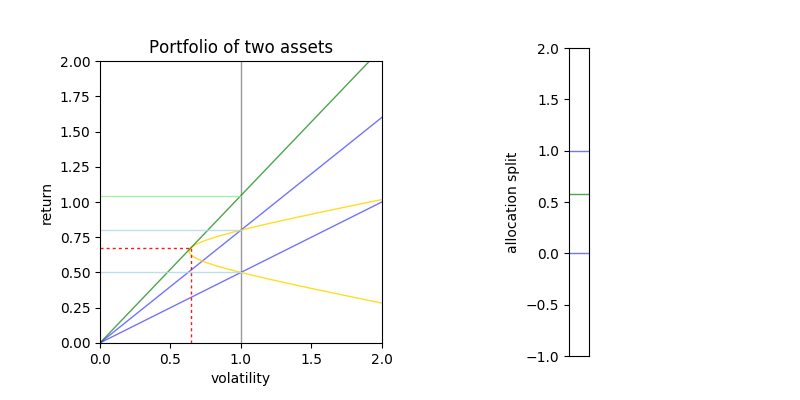

Run me by pressing CTRL+Enter. I should have interactive sliders!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
%matplotlib notebook

def canvas(width, height):
    dpi = 96
    from pylab import rcParams
    rcParams['figure.figsize'] = width, height
canvas(8, 4)

class Portfolio():
    def __init__(self, *, ratios=(1., 1.), corr=0.):
        self._s = None
        self.ratios = np.asarray(ratios)
        self.corr = corr
        self.combined_ret = lambda s: self.ratios@np.asarray([s, 1-s]) if np.isfinite(s) else np.inf
        self.combined_vol = lambda s: np.sqrt(1 - 2*(1-self.corr)*s*(1-s)) if np.isfinite(s) else 0.
        self.vis = self.Vis(self)
        
    def combined_ratio(self):
        if self._s is None:
            num = (self.ratios[0]-self.ratios[1])**2 + 2*(1-self.corr)*self.ratios.prod()
            den = 1 - self.corr**2
            if den==0:
                return np.inf
            return np.sqrt(num/den)
        else:
            num = self.combined_ret(self._s)
            den = self.combined_vol(self._s)
            return num/den
    
    @property
    def s(self):
        if self._s is not None:
            return self._s
        elif self.corr==-1:
            return .5
        elif self.corr==1:
            return np.inf * (-1)**(self.ratios[1]>self.ratios[0])
        return self.ratios@np.asarray([1, -self.corr]) / sum(self.ratios) / (1-self.corr)
    
    
    class Vis():
        RET_LIM = 2
        VOL_LIM = 2
        S_DRAW = 5
        S_LIM = 2
        S_WIDTH = .05 * S_LIM
        MESH = .01
        LW = 1        
        DRAW_BACK = dict(linewidth=LW, c='gray', alpha=.8)
        DRAW_ASSET = dict(linewidth=LW, c='blue', alpha=.55)
        DRAW_PTFL = dict(linewidth=LW, c='green', alpha=.7)
        DRAW_ASSET_DROP = dict(linewidth=LW, c='lightblue', alpha=.8)
        DRAW_PTFL_DROP = dict(linewidth=LW, c='lightgreen', alpha=.8)
        DRAW_FRONT = dict(linewidth=LW, c='gold', alpha=.85)
        DRAW_COMB_DROP = dict(linewidth=LW, c='red', alpha=.9, linestyle=':')
        
        def __init__(self, ptfl):
            self.ptfl = ptfl
            fig, (ax, bx) = self.fig, self.ax = plt.subplots(1, 2)
            # static background lines
            ax.set_title('Portfolio of two assets')
            ax.set_aspect('equal')
            ax.set_xlim(0, self.VOL_LIM) # plot width
            ax.set_ylim(0, self.RET_LIM) # plot height
            ax.plot([1, 1], [0, self.VOL_LIM], **self.DRAW_BACK) # the vol=1 vertical line
            ax.set_xlabel('volatility')
            ax.set_ylabel('return')
            # this is the `s` in [0,1] plot
            bx.set_aspect('equal')
            bx.set_xlim(-self.S_WIDTH, self.S_WIDTH)
            bx.set_ylim(1-self.S_LIM, self.S_LIM)
            bx.set_xticks([])
            bx.set_xticklabels([])
            bx.set_ylabel('allocation split')
            # now the changeable plot elements
            self.ratios = [ax.plot([0, self.VOL_LIM], [0, r*self.VOL_LIM], **self.DRAW_ASSET)[0]
                           for r in ptfl.ratios]
            self.frontier = ax.plot([ptfl.combined_vol(s) for s in np.arange(1-self.S_DRAW, self.S_DRAW, self.MESH)],
                                    [ptfl.combined_ret(s) for s in np.arange(1-self.S_DRAW, self.S_DRAW, self.MESH)],
                                    **self.DRAW_FRONT)[0]
            s = ptfl.s
            ret, vol = ptfl.combined_ret(s), ptfl.combined_vol(s)
            combined_ratio = ptfl.combined_ratio()
            self.combined = ax.plot([0, self.VOL_LIM], [0, combined_ratio*self.VOL_LIM], **self.DRAW_PTFL)[0]
            # the drops
            self.ratios_drop = [ax.plot([0, 1], [r]*2, **self.DRAW_ASSET_DROP)[0] for r in ptfl.ratios]
            self.combined_drop = ax.plot([0, 1], [combined_ratio]*2, **self.DRAW_PTFL_DROP)[0]
            self.combined_ret = ax.plot([0, vol], [ret]*2, **self.DRAW_COMB_DROP)[0]
            self.combined_vol = ax.plot([vol]*2, [0, ret], **self.DRAW_COMB_DROP)[0]
            # the s in between 0 and 1 visualisation
            for r in [0, 1]:
                bx.plot([-self.S_WIDTH, self.S_WIDTH], [r]*2, **self.DRAW_ASSET)
            self.s_tick = bx.plot([-self.S_WIDTH, self.S_WIDTH], [s]*2, **self.DRAW_PTFL)[0]
            
        def update_ratio_i(self, i):
            ptfl = self.ptfl
            self.ratios[i].set_ydata([0, ptfl.ratios[i]*self.VOL_LIM])
            self.ratios_drop[i].set_ydata([ptfl.ratios[i]]*2)
            self.update_frontier()
            self.update_combined()
            
        def update_frontier_and_combined(self):
            self.update_frontier()
            self.update_combined()
            
        def update_frontier(self):
            ptfl = self.ptfl
            self.frontier.set_data([ptfl.combined_vol(s) for s in np.arange(1-self.S_DRAW, self.S_DRAW, self.MESH)],
                                   [ptfl.combined_ret(s) for s in np.arange(1-self.S_DRAW, self.S_DRAW, self.MESH)])
            
        def update_combined(self):
            ptfl = self.ptfl
            s = ptfl.s
            ret, vol = ptfl.combined_ret(s), ptfl.combined_vol(s)
            self.combined_ret.set_data([0, vol], [ret]*2)
            self.combined_vol.set_data([vol]*2, [0, ret])
            combined_ratio = ptfl.combined_ratio()
            self.combined.set_ydata([0, combined_ratio*self.VOL_LIM])
            self.combined_drop.set_ydata([combined_ratio]*2)
            self.s_tick.set_ydata([s]*2)
 

ptfl = Portfolio()
MOVE = .00001

@interact(correlation=(-1, 1, MOVE))
def update_corr(correlation=-0.2):
    ptfl.corr = correlation
    ptfl.vis.update_frontier_and_combined()

@interact(sharpe_ratio_0=(MOVE, ptfl.vis.RET_LIM+0., MOVE))
def update_ratio0(sharpe_ratio_0=.8):
    ptfl.ratios[0] = sharpe_ratio_0
    ptfl.vis.update_ratio_i(0)

@interact(sharpe_ratio_1=(MOVE, ptfl.vis.RET_LIM+0., MOVE))
def update_ratio1(sharpe_ratio_1=.5):
    ptfl.ratios[1] = sharpe_ratio_1
    ptfl.vis.update_ratio_i(1)
    
@interact(asset_allocation=(1.-ptfl.vis.S_LIM, ptfl.vis.S_LIM+0., MOVE))
def customize_s(asset_allocation=ptfl.s):
    ptfl._s = asset_allocation
    ptfl.vis.update_combined()
    ptfl._s = None
    
print("Run me by pressing CTRL+Enter. I should have interactive sliders!")